# Exploration of the data

In [130]:
import os

import pandas as pd

from dotenv import load_dotenv
load_dotenv()
root_data = os.getenv("KAGGLE_FILES_DIR")

In [131]:
dataset_path = os.path.join(os.getcwd(), "..", root_data)

raw_path = os.path.join(dataset_path, 'raw')

labels = pd.read_csv(os.path.join(raw_path, 'metadata.csv'))
print(labels.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


Image names are already changed and classes will be determined by directory structure.

In [132]:
labels.shape

(4600, 6)

# Split dataset into train and test

In [133]:
from pathlib import Path

data_dir = os.path.join(raw_path)
data_dir = Path(data_dir)
data_dir

PosixPath('/Users/isulim/Sages/brain-cnn/notebooks/../data/raw')

Splitting folders into train and test (80%/20% ratio)

In [136]:
import splitfolders

split = os.path.join(dataset_path, 'processed')
os.makedirs(split, exist_ok=True)

splitfolders.ratio(data_dir, output=split, seed=42, ratio=(0.8, 0.2))

Copying files: 4600 files [00:00, 6093.75 files/s]


# Create train and validation datasets

In [137]:
import torchvision

split = os.path.join(dataset_path, 'processed')
train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(split, 'train'), transform=None)
val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(split, 'val'), transform=None)

## Explore image sizes

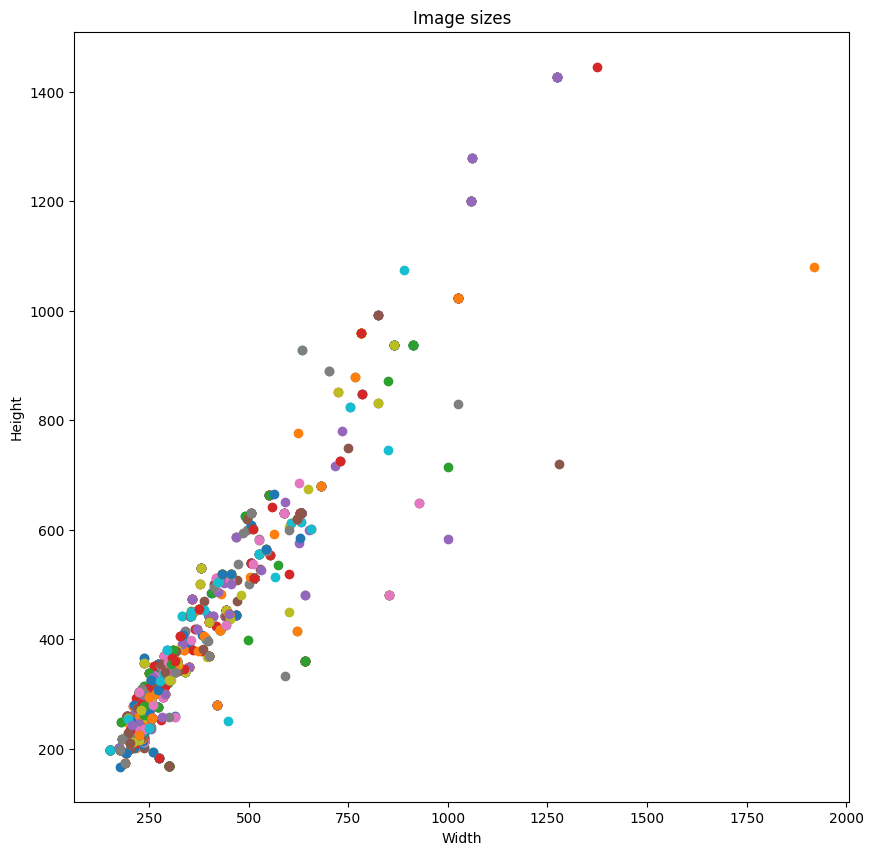

Lowest width: 150, lowest height: 167
Highest width: 1920, highest height: 1446
Average width: 359.0578961674368, average height: 378.1068225061158


In [142]:
import matplotlib.pyplot as plt


highest_width = 0
highest_height = 0

lowest_width = float("inf")
lowest_height = float("inf")

avg_width = 0
avg_height = 0

figure = plt.figure(figsize=(10, 10))

for _ in range(len(train_dataset)):
    img, label = train_dataset[_]
    size = img.size
    
    avg_width += size[0]
    avg_height += size[1]
    
    if size[0] < lowest_width:
        lowest_width = size[0]
    if size[1] < lowest_height:
        lowest_height = size[1]
    
    if size[0] > highest_width:
        highest_width = size[0]
    if size[1] > highest_height:
        highest_height = size[1]
    
    plt.scatter(size[0], size[1])
    

plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image sizes")
plt.show()
print(f"Lowest width: {lowest_width}, lowest height: {lowest_height}")
print(f"Highest width: {highest_width}, highest height: {highest_height}")
print(f"Average width: {avg_width / len(train_dataset)}, average height: {avg_height / len(train_dataset)}")

Looks like resizing to 256x256 will be ok for this dataset.

### Add transforms to the dataset

In [95]:
from torchvision import transforms
transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
])
train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(split, 'train'), transform=transforms)
val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(split, 'val'), transform=transforms)

### Visualize some images from train dataset

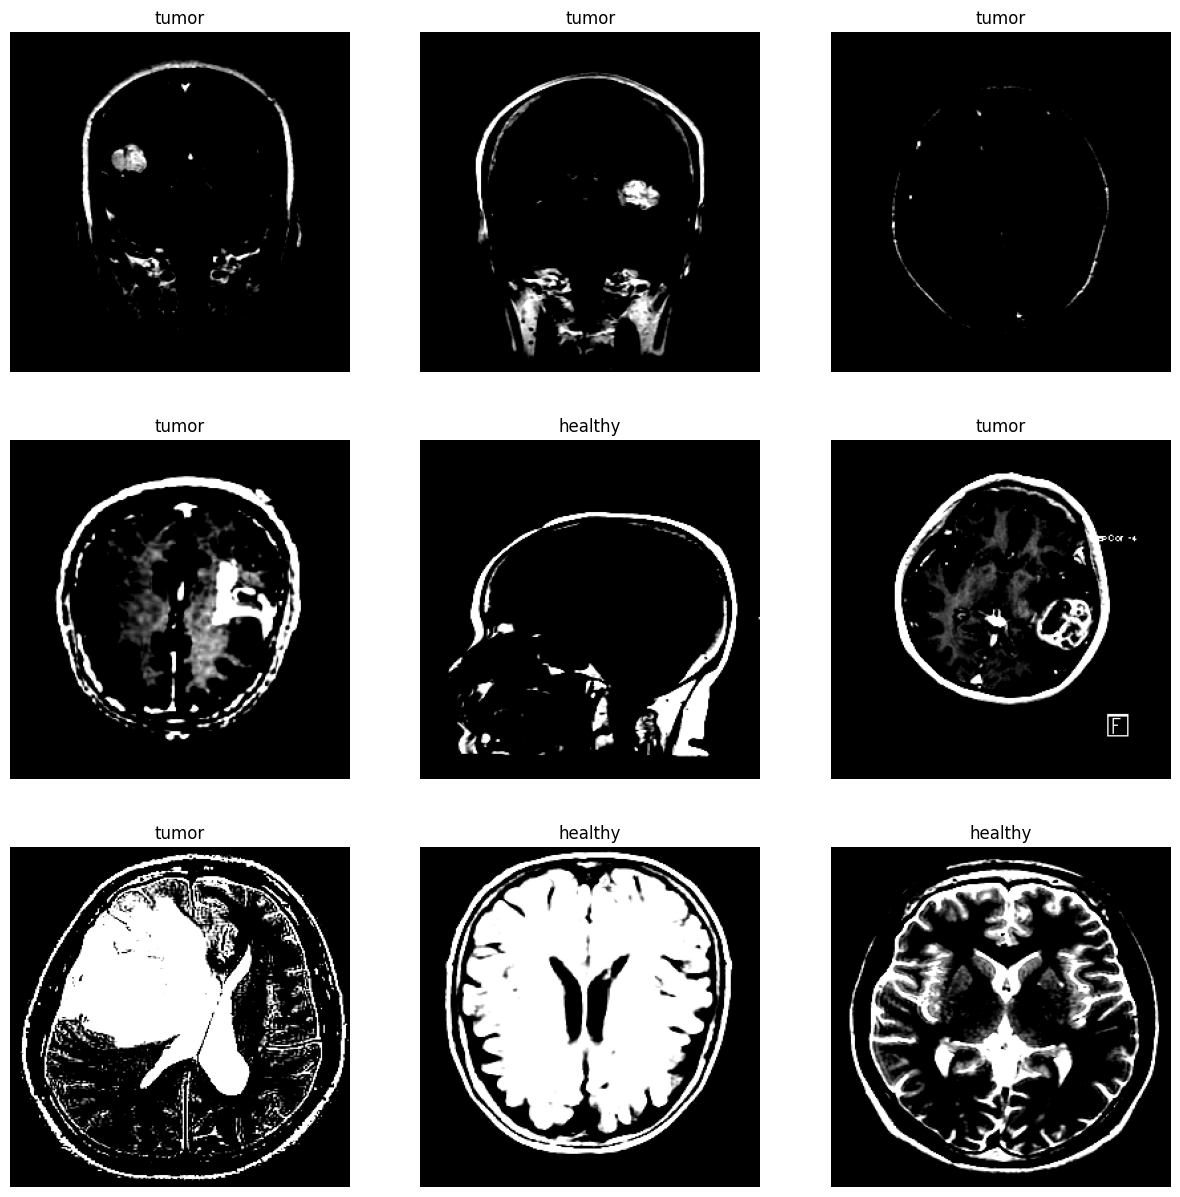

In [96]:
import torch
import numpy as np
import matplotlib.pyplot as plt

labels = {0: "healthy", 1: "tumor"}
figure = plt.figure(figsize=(15, 15))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    